## Импорт библиотек

In [3]:
#импорт библиотек
import glob
import os
import pandas as pd
import numpy as np
import json
import docx
from bs4 import BeautifulSoup as bs
import requests
from tqdm.auto import tqdm, trange
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from nltk.stem import *
from nltk.corpus import stopwords
import string
import re
import pyLDAvis.sklearn
import pyLDAvis
import pyLDAvis.lda_model
import pymorphy2

C:\Users\Дияз\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm


## 1.1 Парсинг данных

Получим список компаний из docx документа

In [2]:
docx = docx.Document('Condidates.docx')
parag = docx.paragraphs

In [3]:
company_docx = []
for i in parag:
    company_docx.append(i.text)
company_docx

['',
 'Здоровье.ру',
 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
 'Skillbox ',
 'Gett',
 'Промобот',
 'Иннотех',
 'Cybersport.Metaratings',
 'MMA.Metaratings',
 'Goose Gaming',
 'ESforce Holding',
 'Vinci Agency',
 'Гэллэри Сервис',
 'Студия Артемия Лебедева',
 'Федерация креативных индустрий',
 'Метарейтинг',
 'СберМаркет',
 'Balance Platform',
 'Московская биржа',
 'Samsung Electronics',
 'Нетология',
 'Дневник МЭШ',
 'Цифровое образование',
 '',
 '',
 '']

В списке присутсвуют пустые строки, которые надо удалить

In [4]:
company_docx = list(filter(None, company_docx))
company_docx

['Здоровье.ру',
 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
 'Skillbox ',
 'Gett',
 'Промобот',
 'Иннотех',
 'Cybersport.Metaratings',
 'MMA.Metaratings',
 'Goose Gaming',
 'ESforce Holding',
 'Vinci Agency',
 'Гэллэри Сервис',
 'Студия Артемия Лебедева',
 'Федерация креативных индустрий',
 'Метарейтинг',
 'СберМаркет',
 'Balance Platform',
 'Московская биржа',
 'Samsung Electronics',
 'Нетология',
 'Дневник МЭШ',
 'Цифровое образование']

### Парсинг Json файла

Получаем список файлов, которые находятся в папке Data

In [5]:
list_json = glob.glob("Data/*.json")

Парсинг файлов

In [6]:
companies_json = {'name':[], 'raiting':[], 'date':[], "text":[], 'about': [], 'industries':[]}
for json_text in list_json:
    with open(json_text, "r", encoding='utf-8') as f: #Чтение файлов
        text = json.load(f)
    for i in text['refs']: # Получение данных из полей "refs", в котором находится информация о содержании текста, и его даты
        name = f.name[5:-5]

        if text['info'] != None: # Получение данных из полей "info", в котором находится информация о содержании текста, и его даты
            companies_json['industries'].append(text["info"]["industries"])
            companies_json['about'].append(text["info"]["about"])
            companies_json['raiting'].append(text["info"]["rate"])
        else:
            companies_json['industries'].append(np.nan)
            companies_json['about'].append(np.nan)
            companies_json['raiting'].append(np.nan)

        companies_json['name'].append(name) # Получение названии компании через название файла
        if i != None:
            companies_json['text'].append(i)

            date = i[1]
            date1 = date['day'] + " " + date["month"] + " " + date["time"]
            companies_json['date'].append(date1)
        else:
            companies_json['text'].append(np.nan)
            companies_json['date'].append(np.nan)

In [7]:
df = pd.DataFrame.from_dict(data=companies_json, orient="index")
df = df.transpose()
df

,name,raiting,date,text,about,industries
0,Cybersport.Metaratings,NaN,8 декабря 09:30,[7 декабря состоялась церемония награждения ла...,NaN,NaN
1,ESforce Holding,NaN,8 декабря 09:30,[7 декабря состоялась церемония награждения ла...,NaN,NaN
2,ESforce Holding,NaN,29 июля 13:50,[Из совместного исследования издателя компьюте...,NaN,NaN
3,ESforce Holding,NaN,9 июля 09:33,[По статистике The Esports Observer за I полов...,NaN,NaN
4,ESforce Holding,NaN,11 апреля 12:43,[Компании SuperData Research и PayPal провели ...,NaN,NaN
...,...,...,...,...,...,...
1111,Федерация креативных индустрий,NaN,30 января 10:43,"[Привет, Хабр! Представляю вашему вниманию пер...",NaN,NaN
1112,Федерация креативных индустрий,NaN,24 апреля 12:37,[Источник\n«Умный человек не делает все ошибки...,NaN,NaN
1113,Федерация креативных индустрий,NaN,12 октября 14:09,"[Привет, Хабр! Сегодня мы решили поделиться с ...",NaN,NaN
1114,Федерация креативных индустрий,NaN,4 сентября 16:44,"[Привет! Меня зовут Никита Бокарев, я креативн...",NaN,NaN


### Заполнение данных об статьях комампний, которые указаны в docx файле

Вывод уникальных названий компаний в новый список.

In [8]:
import numpy as np
uniq_comp = np.unique(companies_json['name'])
print(uniq_comp)

['Cybersport.Metaratings' 'ESforce Holding' 'Gett' 'Goose Gaming'

 'Vinci Agency' 'skillbox' 'Гэллэри Сервис' 'Здоровье.ру' 'Иннотех'

 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений'

 'Промобот' 'Студия Артемия Лебедева' 'Федерация креативных индустрий']


Вывод названий компаний, которые отсутсвуют в Json списке, в новый список

In [9]:
not_in_json = []
for comp in company_docx:
    if comp not in uniq_comp:
        not_in_json.append(comp)
not_in_json

['Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
 'Skillbox ',
 'MMA.Metaratings',
 'Метарейтинг',
 'СберМаркет',
 'Balance Platform',
 'Московская биржа',
 'Samsung Electronics',
 'Нетология',
 'Дневник МЭШ',
 'Цифровое образование']

На основе датасета с данными из Json добавляем информацию о компаниях, которые есть в спике docx документа, но нет в этом датасете. Если такие существуют, то находим информацию и компании на сайте Хабр и получаем текст и дату последних 10 статьей

In [11]:
import re
for name_company in not_in_json: #Перебор всех ссылок на профили компаний, которые есть в списке отсутствующих в Json файле
    name_company1 = '%20'.join(name_company.split())
    url = 'https://habr.com/ru/search/?q='+ name_company1 + "&target_type=companies&order=relevance"
    page = requests.get(url)
    soup = bs(page.text, 'html.parser')
    link = soup.find('a', class_='tm-company-snippet__title')
    description = ""
    rate = ""

    comp_name = name_company
    company_is_real = False
    if link: #Если профиль компании существует, то получаем информацию о компании оттуда
        company_is_real = True
        link = link.get("href")
        url = 'https://habr.com'+ link
        page = requests.get(url)
        soup = bs(page.text, 'html.parser')

        rate = soup.find('span', class_='tm-votes-lever__score-counter tm-votes-lever__score-counter tm-votes-lever__score-counter_rating')
        description = soup.find('span', class_='tm-company-profile__content')
        sphera = soup.findAll('span', class_='tm-company-profile__categories-wrapper')
        spheras = []
        indastries = []
        for i in sphera:
            spheras.append(i.text.strip())
        indastries.append(", ".join(spheras))


    url = 'https://habr.com/ru/search/?q='+ name_company1 + "&target_type=posts&order=relevance"
    print(url)
    page = requests.get(url)
    soup = bs(page.text, 'html.parser')
    pages = soup.find_all('a', class_='tm-pagination__page')
    if len(pages) != 0:
        pages = int(pages[1].text)
    else:
        pages = 1

    for num in range(pages+1):
        url = 'https://habr.com/ru/search/page' + str(num) + '?q='+ name_company1 + "&target_type=posts&order=relevance"
        page = requests.get(url)
        soup = bs(page.text, 'html.parser')

        links = soup.find_all('a', class_='tm-title__link') 

        for link in links:
            url = "https://habr.com" + link.get('href')
            page = requests.get(url)
            soup = bs(page.text, "html.parser")

            date = soup.find('span', class_="tm-article-datetime-published")
            text = soup.find('div', class_="article-formatted-body article-formatted-body article-formatted-body_version-2")

            if text:
                companies_json["text"].append(text.text)
            else:
                companies_json["text"].append(np.nan)

            if description and company_is_real:
                companies_json["about"].append(description.text)
            else:
                companies_json["about"].append(np.nan)

            if rate and company_is_real:
                number = float(re.findall(r'\d+.\d+', rate.text)[0])
                companies_json["raiting"].append(number)
            else:
                companies_json["raiting"].append(np.nan)

            companies_json["name"].append(comp_name)

            if date:
                date_split = date.text.split()

                if (date_split[1] == 'янв'):
                    date_split[1] = 'январь'
                if (date_split[1] == 'фев'):
                    date_split[1] = 'февраль'
                if (date_split[1] == 'мар'):
                    date_split[1] = 'март'
                if (date_split[1] == 'апр'):
                    date_split[1] = 'апрель'
                if (date_split[1] == 'июн'):
                    date_split[1] = 'июнь'          
                if (date_split[1] == 'июн'):
                    date_split[1] = 'июнь' 
                if (date_split[1] == 'июл'):
                    date_split[1] = 'июль' 
                if (date_split[1] == 'авг'):
                    date_split[1] = 'август' 
                if (date_split[1] == 'сен'):
                    date_split[1] = 'сентябрь' 
                if (date_split[1] == 'окт'):
                    date_split[1] = 'октябрь'
                if (date_split[1] == 'ноя'):
                    date_split[1] = 'ноябрь' 
                if (date_split[1] == 'дек'):
                    date_split[1] = 'декабрь'
                if(len(date_split) == 5):
                            date_f = date_split[0] + " " + date_split[1] + " " + date_split[4]
                elif(len(date_split) == 4):
                            date_f = date_split[0] + " " + date_split[1] + " " + date_split[3]        
                companies_json["date"].append(date_f)
            else:
                companies_json["date"].append(np.nan)

            if (company_is_real):
                companies_json["industries"].append(indastries)
            else:
                companies_json["industries"].append(np.nan)


https://habr.com/ru/search/?q=Проект%20по%20использованию%20технологий%20компьютерного%20зрения%20на%20базе%20искусственного%20интеллекта%20(ИИ)%20для%20анализа%20медицинских%20изображений&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Skillbox&target_type=posts&order=relevance

https://habr.com/ru/search/?q=MMA.Metaratings&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Метарейтинг&target_type=posts&order=relevance

https://habr.com/ru/search/?q=СберМаркет&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Balance%20Platform&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Московская%20биржа&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Samsung%20Electronics&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Нетология&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Дневник%20МЭШ&target_type=posts&order=relevance

https://habr.com/ru/search/?q=Цифровое%20образование&target

In [15]:
df = pd.DataFrame.from_dict(data=companies_json, orient="index")
df = df.transpose()
df

,name,raiting,date,text,about,industries
0,Cybersport.Metaratings,NaN,8 декабря 09:30,[7 декабря состоялась церемония награждения ла...,NaN,NaN
1,ESforce Holding,NaN,8 декабря 09:30,[7 декабря состоялась церемония награждения ла...,NaN,NaN
2,ESforce Holding,NaN,29 июля 13:50,[Из совместного исследования издателя компьюте...,NaN,NaN
3,ESforce Holding,NaN,9 июля 09:33,[По статистике The Esports Observer за I полов...,NaN,NaN
4,ESforce Holding,NaN,11 апреля 12:43,[Компании SuperData Research и PayPal провели ...,NaN,NaN
...,...,...,...,...,...,...
4723,Цифровое образование,52.02,28 март 12:52,Словения никогда не попадает в списки самых по...,Учи.ру — крупнейшая в России образовательная п...,"[Веб-разработка, Программное обеспечение, Прои..."
4724,Цифровое образование,52.02,28 март 14:35,Недавно Билл Гейтс выпустил семистраничную ста...,Учи.ру — крупнейшая в России образовательная п...,"[Веб-разработка, Программное обеспечение, Прои..."
4725,Цифровое образование,52.02,17 апрель 20:49,В предыдущих статьях я подробно рассказывал пр...,Учи.ру — крупнейшая в России образовательная п...,"[Веб-разработка, Программное обеспечение, Прои..."
4726,Цифровое образование,52.02,2 мая 09:41,"«Ты уникален, бро!» — вот что сейчас хочет вну...",Учи.ру — крупнейшая в России образовательная п...,"[Веб-разработка, Программное обеспечение, Прои..."


Сохранение данных в csv формате

In [3]:
# Запись файла
FILE_NAME = "habr.csv"
df = pd.DataFrame.from_dict(data=companies_json, orient="index")
df = df.transpose()
df.columns=['name', 'raiting', 'date', "text", 'about', 'industries']
df.to_csv(FILE_NAME, index=False)

NameError: name 'companies_json' is not defined

In [ ]:
# Чтение файла
df = pd.read_csv('habr.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 4728 entries, 0 to 4727

Data columns (total 6 columns):

 #   Column      Non-Null Count  Dtype  

---  ------      --------------  -----  

 0   name        4728 non-null   object 

 1   raiting     3373 non-null   float64

 2   date        4720 non-null   object 

 3   text        2216 non-null   object 

 4   about       3373 non-null   object 

 5   industries  3373 non-null   object 

dtypes: float64(1), object(5)

memory usage: 221.8+ KB


__Вывод__: получили данные статьей из Json файла и информацию об компаниях и их статьях с сайта Habr. Также заполнили недостоющую информацию о компаниях в Json файле, у которых остутсвовала информация. Сформировали все данные с единый датасет

## 1.2 Формирование структуры набора данных

Проверка на пустые значения

In [ ]:
df.isnull().sum()

name             0
raiting       1355
date             8
text          2512
about         1355
industries    1355
dtype: int64

Определим нужные атрибуты, для номинации премии Рунета.
Название для определения победителя, текст определения сферы в номинации и рейтинг. Остальные артибуты удалим

In [ ]:
df = df.drop(['about'], axis=1)
df = df.drop(['date'], axis=1)
df = df.drop(['industries'], axis=1)

Удалим статьи, которые содержат пустые значения

In [ ]:
df = df.dropna()

In [ ]:
df

,name,raiting,text
147,skillbox,113.82,"[""Сравниваем традиционный способ извлечения зн..."
148,skillbox,113.82,['Издание «Ведомости» поговорило с участниками...
149,skillbox,113.82,"['Александр Нозик, физик и программист, руково..."
150,skillbox,113.82,['Всем привет! В конце 21-го года состоялся п...
151,skillbox,113.82,['1 марта VK запустила информационную кампанию...
...,...,...,...
4723,Цифровое образование,52.02,Словения никогда не попадает в списки самых по...
4724,Цифровое образование,52.02,Недавно Билл Гейтс выпустил семистраничную ста...
4725,Цифровое образование,52.02,В предыдущих статьях я подробно рассказывал пр...
4726,Цифровое образование,52.02,"«Ты уникален, бро!» — вот что сейчас хочет вну..."


__Вывод:__ определили нужные атрибуты, которые будем использовать для последующей обработки. Удалили статьи, у которых были пустые поля.

### 1.3 Предварительная обработка текстовых данных 

Создадим функции для удаления лишних слов и символов

In [11]:
import string
from pymystem3 import Mystem
from tqdm.auto import tqdm, trange
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer as snow 

def remove_punctuation(text): #Функция удаления знаков препинания
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text): #Функция удаления чисел
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text): #Функция удаления пробелов
    return re.sub(r'\s+', ' ', text, flags=re.I)

C:\Users\Дияз\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df['text'])]

100%|██████████| 1213/1213 [00:02<00:00, 458.74it/s]


In [10]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian") #создание списка стоп-слов
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'это']) #Дополнение стоп-слов

### Токенизация

In [ ]:
sw_texts_list = [] #создание списка текста с удаленными стоп словами
for text in tqdm(prep_text):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df['text_sw'] = sw_texts_list

100%|██████████| 1213/1213 [00:07<00:00, 152.81it/s]


### Стемминг

In [ ]:
stemmer = snow("russian") 
stemmed_texts_list = [] #создание списка стемминга слов
for text in tqdm(df["text_sw"]):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)

df['text_stem'] = stemmed_texts_list

100%|██████████| 1213/1213 [00:59<00:00, 20.26it/s]


### Лемитизация

In [ ]:
from pymystem3 import Mystem
from tqdm.auto import tqdm, trange
mystem = Mystem() 
lemm_texts_list = [] # создание и заполенение списка с текстом статей, где словам присвоили начальную форму.
for text in tqdm(df["text_sw"]):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
    
df['text_lemm'] = lemm_texts_list

100%|██████████| 1213/1213 [17:32<00:00,  1.15it/s]


In [ ]:
df['text_sw'].drop
df['text_stem'].drop

<bound method Series.drop of 147     сравнива традицион способ извлечен значен дест...
148     издан ведом поговор участник рынк edtech котор...
149     александр нозик физик программист руководител ...
150     всем привет конц го год состоя перв хакатон ис...
151     март vk запуст информацион кампан поддержк нек...
                              ...                        
4723    словен попада списк сам популярн стран релокей...
4724    недавн билл гейтс выпуст семистраничн стат иск...
4725    предыдущ стат подробн рассказыва налогов валют...
4726    уникал бро — хочет внуш клиент кажд бизнес кон...
4727    программистк встроен rtos мар горбунов fpga пл...
Name: text_stem, Length: 1213, dtype: object>

In [ ]:
df

,name,raiting,text,text_sw,text_stem,text_lemm
147,skillbox,113.82,"[""Сравниваем традиционный способ извлечения зн...",сравниваем традиционный способ извлечения знач...,сравнива традицион способ извлечен значен дест...,сравнивать традиционный способ извлечение знач...
148,skillbox,113.82,['Издание «Ведомости» поговорило с участниками...,издание ведомости поговорило участниками рынка...,издан ведом поговор участник рынк edtech котор...,издание ведомость поговорить участник рынок ed...
149,skillbox,113.82,"['Александр Нозик, физик и программист, руково...",александр нозик физик программист руководитель...,александр нозик физик программист руководител ...,александр нозик физик программист руководитель...
150,skillbox,113.82,['Всем привет! В конце 21-го года состоялся п...,всем привет конце го года состоялся первый хак...,всем привет конц го год состоя перв хакатон ис...,привет конец го год состояться первый хакатон ...
151,skillbox,113.82,['1 марта VK запустила информационную кампанию...,марта vk запустила информационную кампанию под...,март vk запуст информацион кампан поддержк нек...,март vk запускать информационный кампания подд...
...,...,...,...,...,...,...
4723,Цифровое образование,52.02,Словения никогда не попадает в списки самых по...,словения попадает списки самых популярных стра...,словен попада списк сам популярн стран релокей...,словения попадать список самый популярный стра...
4724,Цифровое образование,52.02,Недавно Билл Гейтс выпустил семистраничную ста...,недавно билл гейтс выпустил семистраничную ста...,недавн билл гейтс выпуст семистраничн стат иск...,недавно билл гейтс выпускать семистраничный ст...
4725,Цифровое образование,52.02,В предыдущих статьях я подробно рассказывал пр...,предыдущих статьях подробно рассказывал налого...,предыдущ стат подробн рассказыва налогов валют...,предыдущий статья подробно рассказывать налого...
4726,Цифровое образование,52.02,"«Ты уникален, бро!» — вот что сейчас хочет вну...",уникален бро — хочет внушить клиенту каждый би...,уникал бро — хочет внуш клиент кажд бизнес кон...,уникальный бро — хотеть внушать клиент кажды...


### Выделение частей речи

Процесс преобразования предложения в формы, то есть в список слов или кортежей (каждый кортеж имеет вид [слово, часть речи]).

In [5]:
morph = pymorphy2.MorphAnalyzer(lang='ru')

C:\Users\Дияз\AppData\Roaming\Python\Python310\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

  args, varargs, kw, default = inspect.getargspec(cls.__init__)

C:\Users\Дияз\AppData\Roaming\Python\Python310\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

  args, varargs, kw, default = inspect.getargspec(cls.__init__)

C:\Users\Дияз\AppData\Roaming\Python\Python310\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

  args, varargs, kw, default = inspect.getargspec(cls.__init__)

C:\Users\Дияз\AppData\Roaming\Python\Python310\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0

__pymorphy2__ умеет разбирать не только словарные слова; для несловарных слов автоматически задействуется предсказатель.

In [6]:
ps_text_list = []
for text in tqdm(df['text_lemm']):
    try:
        words = word_tokenize(text)
        text_list = []
        for i in range(len(words)):
            p = morph.parse(words[i])[0]
            text_list.append("(" + words[i] + ", " + str(p.tag.POS) + ")")
        ps_text_list.append(text_list)
    except Exception as e:
        print(e)
df['text_ps'] = ps_text_list

100%|██████████| 1213/1213 [02:30<00:00,  8.06it/s]


In [7]:
df.head()

,name,raiting,text,text_sw,text_stem,text_lemm,text_ps
0,skillbox,113.82,"[""Сравниваем традиционный способ извлечения зн...",сравниваем традиционный способ извлечения знач...,сравнива традицион способ извлечен значен дест...,сравнивать традиционный способ извлечение знач...,"[(сравнивать, INFN), (традиционный, ADJF), (сп..."
1,skillbox,113.82,['Издание «Ведомости» поговорило с участниками...,издание ведомости поговорило участниками рынка...,издан ведом поговор участник рынк edtech котор...,издание ведомость поговорить участник рынок ed...,"[(издание, NOUN), (ведомость, NOUN), (поговори..."
2,skillbox,113.82,"['Александр Нозик, физик и программист, руково...",александр нозик физик программист руководитель...,александр нозик физик программист руководител ...,александр нозик физик программист руководитель...,"[(александр, NOUN), (нозик, NOUN), (физик, NOU..."
3,skillbox,113.82,['Всем привет! В конце 21-го года состоялся п...,всем привет конце го года состоялся первый хак...,всем привет конц го год состоя перв хакатон ис...,привет конец го год состояться первый хакатон ...,"[(привет, NOUN), (конец, NOUN), (го, NOUN), (г..."
4,skillbox,113.82,['1 марта VK запустила информационную кампанию...,марта vk запустила информационную кампанию под...,март vk запуст информацион кампан поддержк нек...,март vk запускать информационный кампания подд...,"[(март, NOUN), (vk, None), (запускать, INFN), ..."


In [8]:
df.to_csv('habr_f.csv', index=False)

## 1.4 Поиск n-грамм. Векторизация текстов

__Мешок слов__ - решает проблему размерности по одной оси. Количество строк определяется количеством документов. Однако, этот метод не учитывает важность того или иного токена, ведь одно слово может повторятся по несколько раз.

__TF-IDF__ - это способ векторизации текста, отражающий важность слова в документе, а не только частоту его появления.

__Word Embeddings__ - векторное представление слов. Векторы можно складывать, вычитать, сравнивать.

In [6]:
df.isnull().sum()

name         0
raiting      0
text         0
text_sw      0
text_stem    0
text_lemm    0
text_ps      0
dtype: int64

In [4]:
# Чтение файла
df = pd.read_csv('habr_f.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1213 entries, 0 to 1212

Data columns (total 7 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   name       1213 non-null   object 

 1   raiting    1213 non-null   float64

 2   text       1213 non-null   object 

 3   text_sw    1213 non-null   object 

 4   text_stem  1213 non-null   object 

 5   text_lemm  1213 non-null   object 

 6   text_ps    1213 non-null   object 

dtypes: float64(1), object(6)

memory usage: 66.5+ KB


In [10]:
df

,name,raiting,text,text_sw,text_stem,text_lemm,text_ps
0,skillbox,113.82,"[""Сравниваем традиционный способ извлечения зн...",сравниваем традиционный способ извлечения знач...,сравнива традицион способ извлечен значен дест...,сравнивать традиционный способ извлечение знач...,"['(сравнивать, INFN)', '(традиционный, ADJF)',..."
1,skillbox,113.82,['Издание «Ведомости» поговорило с участниками...,издание ведомости поговорило участниками рынка...,издан ведом поговор участник рынк edtech котор...,издание ведомость поговорить участник рынок ed...,"['(издание, NOUN)', '(ведомость, NOUN)', '(пог..."
2,skillbox,113.82,"['Александр Нозик, физик и программист, руково...",александр нозик физик программист руководитель...,александр нозик физик программист руководител ...,александр нозик физик программист руководитель...,"['(александр, NOUN)', '(нозик, NOUN)', '(физик..."
3,skillbox,113.82,['Всем привет! В конце 21-го года состоялся п...,всем привет конце го года состоялся первый хак...,всем привет конц го год состоя перв хакатон ис...,привет конец го год состояться первый хакатон ...,"['(привет, NOUN)', '(конец, NOUN)', '(го, NOUN..."
4,skillbox,113.82,['1 марта VK запустила информационную кампанию...,марта vk запустила информационную кампанию под...,март vk запуст информацион кампан поддержк нек...,март vk запускать информационный кампания подд...,"['(март, NOUN)', '(vk, None)', '(запускать, IN..."
...,...,...,...,...,...,...,...
1208,Цифровое образование,52.02,Словения никогда не попадает в списки самых по...,словения попадает списки самых популярных стра...,словен попада списк сам популярн стран релокей...,словения попадать список самый популярный стра...,"['(словения, NOUN)', '(попадать, INFN)', '(спи..."
1209,Цифровое образование,52.02,Недавно Билл Гейтс выпустил семистраничную ста...,недавно билл гейтс выпустил семистраничную ста...,недавн билл гейтс выпуст семистраничн стат иск...,недавно билл гейтс выпускать семистраничный ст...,"['(недавно, ADVB)', '(билл, NOUN)', '(гейтс, N..."
1210,Цифровое образование,52.02,В предыдущих статьях я подробно рассказывал пр...,предыдущих статьях подробно рассказывал налого...,предыдущ стат подробн рассказыва налогов валют...,предыдущий статья подробно рассказывать налого...,"['(предыдущий, ADJF)', '(статья, NOUN)', '(под..."
1211,Цифровое образование,52.02,"«Ты уникален, бро!» — вот что сейчас хочет вну...",уникален бро — хочет внушить клиенту каждый би...,уникал бро — хочет внуш клиент кажд бизнес кон...,уникальный бро — хотеть внушать клиент кажды...,"['(уникальный, ADJF)', '(бро, None)', '(—, Non..."


### Векторизация мешок слов

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)
count_matrix = vectorizer.fit_transform(df['text_lemm'])

NameError: name 'russian_stopwords' is not defined

In [ ]:
count_matrix.shape

(1213, 352883)

In [ ]:
vectorizer.get_feature_names_out()[:50]

array(['aa', 'aa telвводим', 'aa telвводим тегикогда', 'ab', 'ab bio',
       'ab bio id', 'ab name', 'ab name frank', 'abap', 'abap groovy',
       'abap groovy haskell', 'abbyy', 'abbyy skillbox',
       'abbyy skillbox спортмастер', 'abbyy россия',
       'abbyy россия дмитрий', 'abbyy спортмастер',
       'abbyy спортмастер магнит', 'abc', 'abcd', 'abi', 'able',
       'able to', 'about', 'about one', 'about red', 'about red возможно',
       'about the', 'about this', 'aboutчастный', 'aboutчастный случай',
       'aboutчастный случай нужно', 'above', 'above rush',
       'above rush royale', 'abs', 'absolute', 'absolute left',
       'absolute top', 'absolute свойство', 'absolute свойство top',
       'absolute специально', 'absolute специально показывать',
       'abstract', 'abstract lizardв',
       'abstract lizardв программирование', 'ac', 'academia', 'academic',
       'academy'], dtype=object)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
RAND = 10
lda_model = LatentDirichletAllocation(n_components=11)

In [ ]:
lda_model.fit(count_matrix)

LatentDirichletAllocation(n_components=11)

### Векторизация TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [ ]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])

CPU times: total: 4.47 s

Wall time: 12 s


In [ ]:
tfidf_matrix.shape

(1213, 10000)

In [ ]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['academy', 'academy hedu', 'action', 'add', 'adobe', 'advanced',
       'after', 'agile', 'agima', 'ai', 'all', 'amazon', 'amd', 'an',
       'analysis', 'analytics', 'and', 'android', 'android ios',
       'android разработка', 'android разработчик', 'angular', 'any',
       'apache', 'api', 'app', 'app store', 'append', 'apple',
       'application', 'ar', 'ar vr', 'are', 'arm', 'array', 'art', 'as',
       'at', 'auto', 'automation', 'awards', 'back', 'backend',
       'backend разработка', 'backend разработчик', 'background', 'badoo',
       'bank', 'based', 'bash', 'basic', 'be', 'be tester', 'before',
       'best', 'beta', 'bi', 'big', 'big data', 'bit', 'black', 'blog',
       'bluetooth', 'body', 'boolean', 'bot', 'box', 'brains', 'build',
       'business', 'but', 'by', 'call', 'can', 'capital', 'case', 'cd',
       'center', 'ceo', 'ces', 'change', 'channel', 'chatgpt', 'check',
       'chrome', 'chukqa', 'ci', 'ci cd', 'cisco', 'class', 'close',
       'cloud', 'club

## 1.4.4 Векторизация Word Embeddings

In [9]:
import nltk

In [8]:
from gensim.models import Word2Vec

In [16]:
Bigger_list=[]
for i in df['text_lemm']:
     li = list(word_tokenize(i))
     Bigger_list.append(li)
Model= Word2Vec(Bigger_list,min_count=1,vector_size=300,workers=4)

In [21]:
Model.wv.key_to_index

{'n': 0,
 '—': 1,
 'который': 2,
 'год': 3,
 'r': 4,
 'работа': 5,
 'компания': 6,
 'свой': 7,
 'курс': 8,
 'человек': 9,
 'работать': 10,
 'время': 11,
 'мочь': 12,
 '–': 13,
 'проект': 14,
 'новый': 15,
 'обучение': 16,
 'данные': 17,
 'первый': 18,
 'задача': 19,
 'система': 20,
 'становиться': 21,
 'получать': 22,
 'также': 23,
 'самый': 24,
 'xa': 25,
 'разработчик': 26,
 'команда': 27,
 'каждый': 28,
 'очень': 29,
 'it': 30,
 'решение': 31,
 'программа': 32,
 'разработка': 33,
 'нужно': 34,
 'вопрос': 35,
 'образование': 36,
 'онлайн': 37,
 'использовать': 38,
 'рынок': 39,
 'наш': 40,
 'понимать': 41,
 'начинать': 42,
 'например': 43,
 'процесс': 44,
 'давать': 45,
 'приложение': 46,
 'сделать': 47,
 'проблема': 48,
 'тестирование': 49,
 'специалист': 50,
 'студент': 51,
 'создавать': 52,
 'возможность': 53,
 'большой': 54,
 'просто': 55,
 'опыт': 56,
 'технология': 57,
 'делать': 58,
 'код': 59,
 'язык': 60,
 'информация': 61,
 'помогать': 62,
 'знание': 63,
 'должный': 64,
 'ч

In [22]:
df.head()

,name,raiting,text,text_sw,text_stem,text_lemm,text_ps
0,skillbox,113.82,"[""Сравниваем традиционный способ извлечения зн...",сравниваем традиционный способ извлечения знач...,сравнива традицион способ извлечен значен дест...,сравнивать традиционный способ извлечение знач...,"['(сравнивать, INFN)', '(традиционный, ADJF)',..."
1,skillbox,113.82,['Издание «Ведомости» поговорило с участниками...,издание ведомости поговорило участниками рынка...,издан ведом поговор участник рынк edtech котор...,издание ведомость поговорить участник рынок ed...,"['(издание, NOUN)', '(ведомость, NOUN)', '(пог..."
2,skillbox,113.82,"['Александр Нозик, физик и программист, руково...",александр нозик физик программист руководитель...,александр нозик физик программист руководител ...,александр нозик физик программист руководитель...,"['(александр, NOUN)', '(нозик, NOUN)', '(физик..."
3,skillbox,113.82,['Всем привет! В конце 21-го года состоялся п...,всем привет конце го года состоялся первый хак...,всем привет конц го год состоя перв хакатон ис...,привет конец го год состояться первый хакатон ...,"['(привет, NOUN)', '(конец, NOUN)', '(го, NOUN..."
4,skillbox,113.82,['1 марта VK запустила информационную кампанию...,марта vk запустила информационную кампанию под...,март vk запуст информацион кампан поддержк нек...,март vk запускать информационный кампания подд...,"['(март, NOUN)', '(vk, None)', '(запускать, IN..."


### Добавление ключевых слов, биграмм и триграмм

In [ ]:
for i in range(len(df)):
    tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,1))
    tfidf_matrix= tfidf_vectorizer.fit_transform([df.loc[i, 'text_lemm']]).toarray()
    df.loc[i, 'keyword'] = str(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix[0])))
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(2,2))
    tfidf_matrix= tfidf_vectorizer.fit_transform([df.loc[i, 'text_lemm']]).toarray()
    df.loc[i, 'bigrams'] = str(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix[0])))
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(3,3))
    tfidf_matrix= tfidf_vectorizer.fit_transform([df.loc[i, 'text_lemm']]).toarray()
    df.loc[i, 'trigrams'] = str(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix[0])))

In [ ]:
df.head()

,name,raiting,text,text_sw,text_stem,text_lemm,keyword,bigrams,trigrams
0,skillbox,113.82,"[""Сравниваем традиционный способ извлечения зн...",сравниваем традиционный способ извлечения знач...,сравнива традицион способ извлечен значен дест...,сравнивать традиционный способ извлечение знач...,"{'address': 0.08978048937499296, 'age': 0.0256...","{'address city': 0.06482037235521644, 'address...","{'address city console': 0.03202563076101743, ..."
1,skillbox,113.82,['Издание «Ведомости» поговорило с участниками...,издание ведомости поговорило участниками рынка...,издан ведом поговор участник рынк edtech котор...,издание ведомость поговорить участник рынок ed...,"{'commerce': 0.035646150289975954, 'day': 0.03...","{'commerce налог': 0.04962916669854651, 'day m...","{'commerce налог прибыль': 0.0519174131651165,..."
2,skillbox,113.82,"['Александр Нозик, физик и программист, руково...",александр нозик физик программист руководитель...,александр нозик физик программист руководител ...,александр нозик физик программист руководитель...,"{'big': 0.011591914445681107, 'casus': 0.01159...","{'big data': 0.024761275912089115, 'casus scie...","{'big data сделать': 0.026207120918047958, 'ca..."
3,skillbox,113.82,['Всем привет! В конце 21-го года состоялся п...,всем привет конце го года состоялся первый хак...,всем привет конц го год состоя перв хакатон ис...,привет конец го год состояться первый хакатон ...,"{'bi': 0.014552479917500617, 'day': 0.01455247...","{'bi инструмент': 0.0265092566603795, 'day mon...",{'bi инструмент позволять': 0.0279072786092973...
4,skillbox,113.82,['1 марта VK запустила информационную кампанию...,марта vk запустила информационную кампанию под...,март vk запуст информацион кампан поддержк нек...,март vk запускать информационный кампания подд...,"{'cloud': 0.05285164225816899, 'day': 0.052851...","{'cloud solutions': 0.07273929674533079, 'day ...","{'cloud solutions нко': 0.07453559924999299, '..."


In [ ]:
df.to_csv('dataset.csv', index=False )

## 1.5 Разведочный анализ

In [ ]:
with open('Target.json', "r",encoding="utf-8") as my_file: #Открытие json файла
    target_json = my_file.read() #чтение

In [ ]:
import json

In [ ]:
targets = json.loads(target_json) #загрузка

In [ ]:
namecomp = []
nominat = []
for i in range(len(targets['list'])):
    namecomp.append(targets['list'][i]['Сompany'])
    nominat.append(targets['list'][i]['Nominations'])

In [ ]:
targets = pd.DataFrame()

In [ ]:
targets['namecompany'] = namecomp
targets['nomination'] = nominat

In [ ]:
targets

,namecompany,nomination
0,Здоровье.ру,Здоровье и медицина
1,Проект по использованию технологий компьютерно...,Здоровье и медицина
2,Skillbox,"Наука, технологии и инновации"
3,Gett,"Наука, технологии и инновации"
4,Промобот,"Наука, технологии и инновации"
5,Иннотех,"Наука, технологии и инновации"
6,Cybersport.Metaratings,Игровая индустрия и киберспорт
7,MMA.Metaratings,Игровая индустрия и киберспорт
8,Goose Gaming,Игровая индустрия и киберспорт
9,ESforce Holding,Игровая индустрия и киберспорт


In [ ]:
targetscomp = []
for i in range(len(df['name'])):
        k = 0
        for j in range(len(targets['namecompany'])):
            if(df['name'][i].lower().strip() == targets['namecompany'][j].lower().strip()):
                targetscomp.append(targets['nomination'][j])
            else:
                k = k + 1
        if(k == len(targets['namecompany'])):
            targetscomp.append('Нет номинации')   

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, технологии и инновации

Наука, т

In [ ]:
len(targetscomp)

1213

In [ ]:
df['target'] = targetscomp

In [ ]:
df.to_csv('dataset.csv', index=False)

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['target2']= label_encoder.fit_transform(df['target'])

<Axes: ylabel='count'>

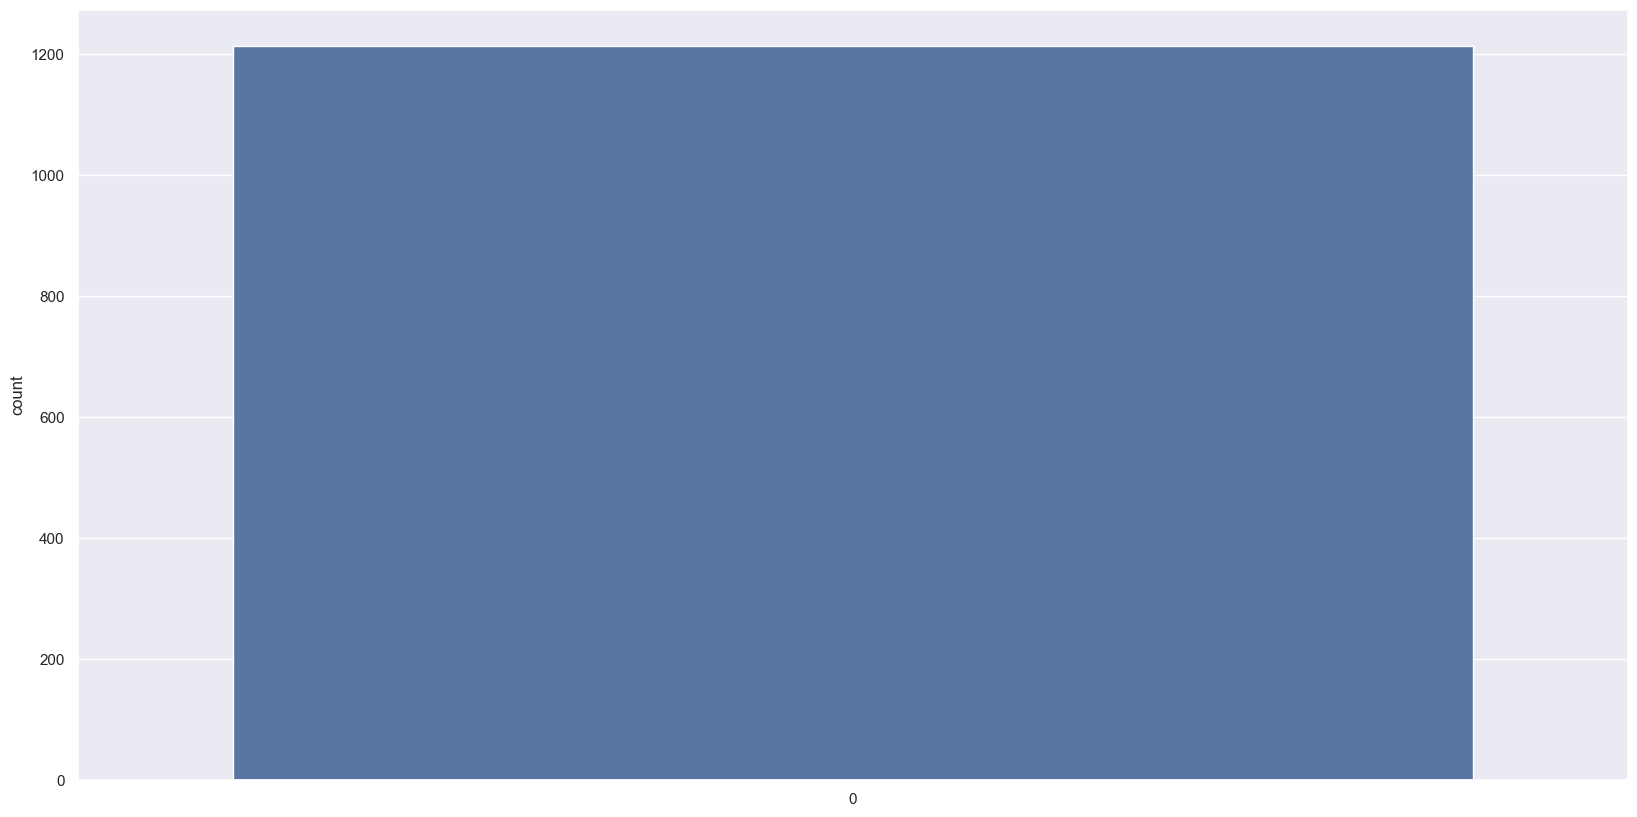

In [ ]:
sns.countplot(df['target2'])

C:\Users\Дияз\AppData\Local\Temp\ipykernel_3376\3588825015.py:1: UserWarning: 



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.



Please adapt your code to use either `displot` (a figure-level function with

similar flexibility) or `histplot` (an axes-level function for histograms).



For a guide to updating your code to use the new functions, please see

https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



  sns_plot = sns.distplot(df['target2'])


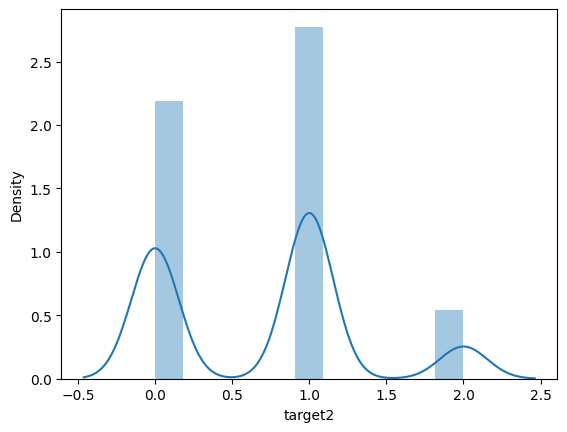

In [ ]:
sns_plot = sns.distplot(df['target2'])
fig = sns_plot.get_figure()

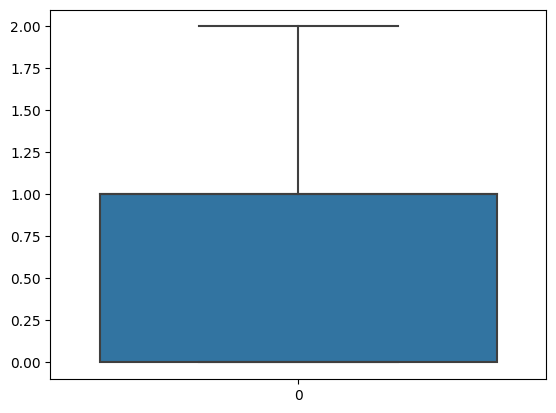

In [ ]:
sns_plot = sns.boxplot(df['target2'])
fig = sns_plot.get_figure()

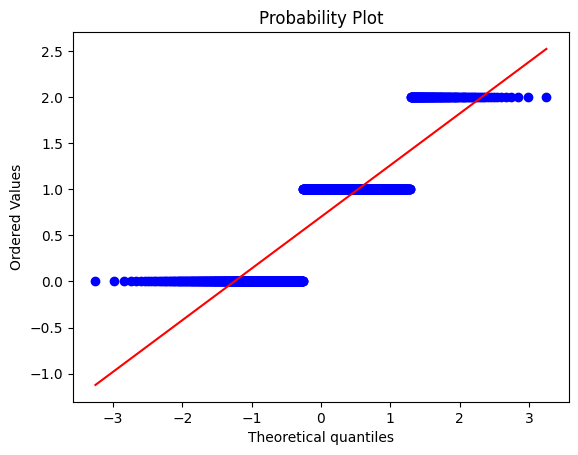

In [ ]:
stats.probplot(df['target2'], dist = "norm", plot=pylab)
pylab.show()

<Axes: xlabel='target', ylabel='raiting'>

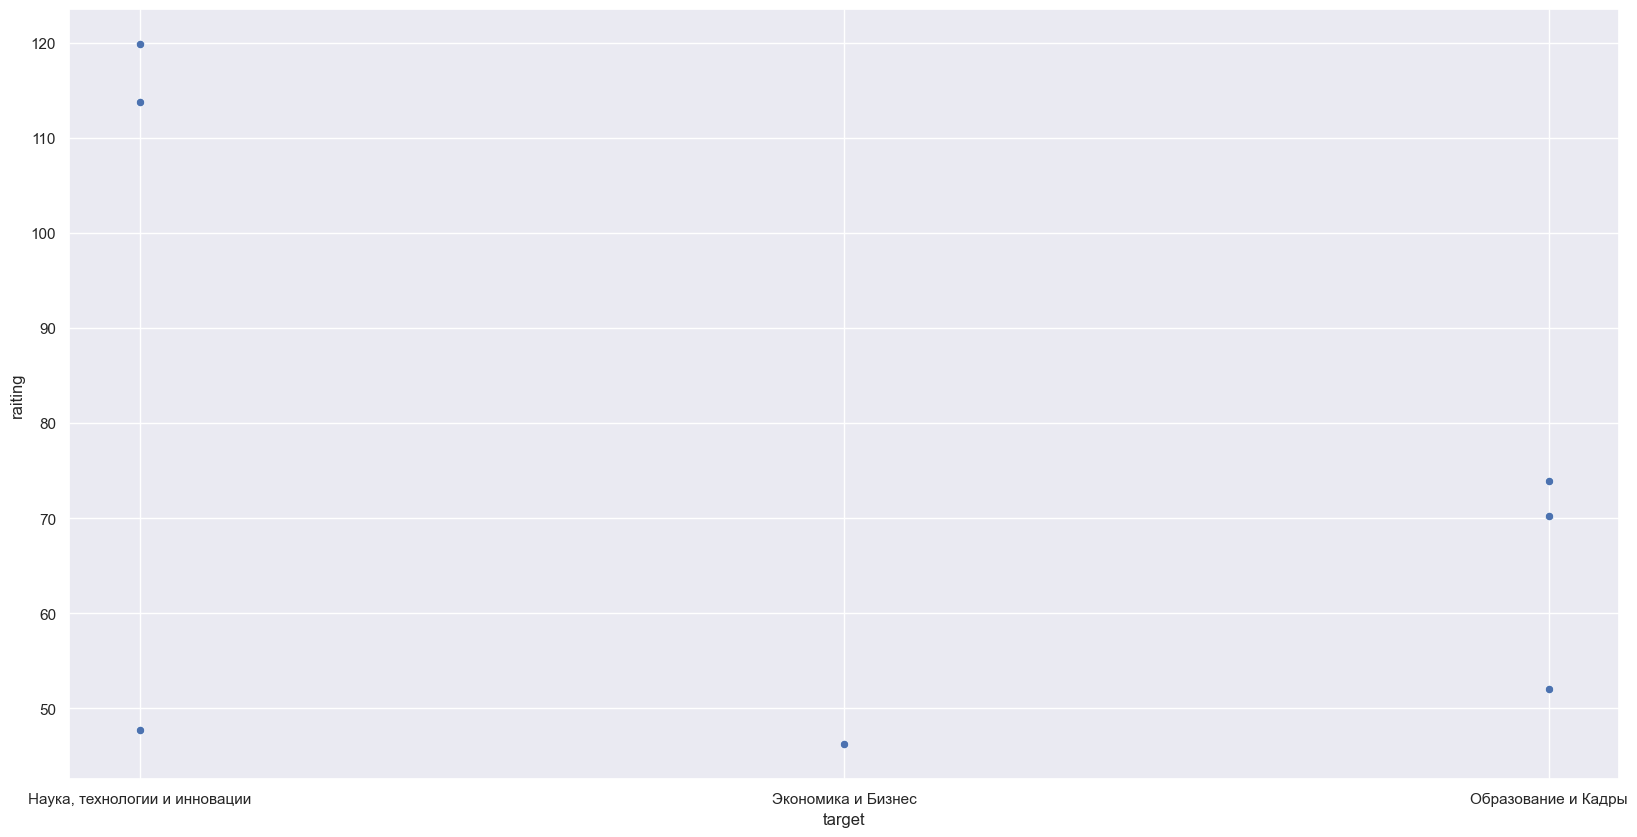

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sns.scatterplot(data=df, x="target", y="raiting")

In [ ]:
df = pd.read_csv('dataset.csv')